In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

from scholte import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
h0 =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02, 0.0]
vs0 = [0.0233, 0.0522, 0.0906, 0.125 , 0.20 , 0.25, 1.5]

# h =  [0.100, 0.005, 0.010, 0.025, 0.0]
# vs = [0, 0.038, 0.043, 0.080, 0.600]

k_obs,f_obs=load_dispersion_observations()

In [3]:
# do_mcmc_8param(k_obs,f_obs, h0, vs0, N = 100, 
#                 filename='three-modes.pickle', 
#                 step_size = 2e-3,
#                 f_sensitivity = 0.01,
#                 verbose=False)

In [4]:
import pickle
x = pickle.load(open('three-modes.pickle', 'rb'))
n = x.shape[0]
y = x[int(n/3):,:]
ymean = np.mean(y,axis=0)

In [5]:
# One-mode tuned model
h1 =  np.hstack([0,np.array([0.100, 0.005, 0.010, 0.025, 0.0])*1000,300])
v1 = [0,0, 0.038, 0.043, 0.080, 0.600,0.6]

In [13]:
z = np.hstack([0,np.cumsum(h0)*1000,500])
mean_vs = np.hstack([0,ymean[8:],ymean[-1],ymean[-1]])

one_mode_vs = np.array(v1)*1000
one_mode_z = np.cumsum(h1)

In [39]:
# set up the initial velocity model
h =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02, 0.0]
vs = np.array([0, 0.0233, 0.0522, 0.0906, 0.125 , 0.20 , 0.25, 1.5])
vp = np.ones_like(vs) * 1.6
vp[0]=1.5
rho = np.ones_like(vs) * 1.5
rho[0]=1

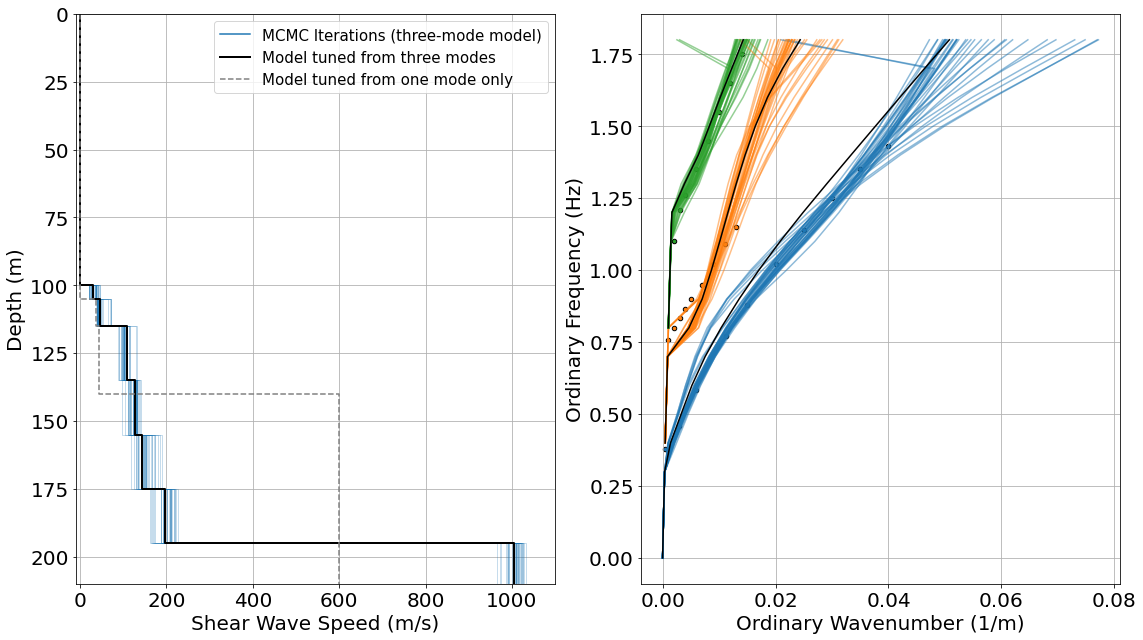

In [97]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
fig.patch.set_facecolor('w')


ax[0].plot(0,0,label='MCMC Iterations (three-mode model)')
ind = np.linspace(0,y.shape[0]-1).astype(int)
ind = np.random.shuffle(ind)

for j,xx in enumerate(y[ind,:].squeeze()):
    if j > 36: break
        
    '''
    First, plot the modeled velocity structure
    '''
    this_vs = np.hstack([0,xx[8:],xx[-1],xx[-1]])
    ax[0].step(this_vs, z, c='C0',alpha=0.5,linewidth=0.5)
    
    '''
    Second, plot the modeled dispersion curves
    '''
    this_h = xx[:8]/1000
    this_vs_input = xx[7:]/1000
    f,k = pysurf96(this_h,vp,this_vs_input,rho)
    for kk,ff,i in zip(k,f,range(len(k))):
        ax[1].plot(kk,ff,'-',c=f'C{i}',alpha=0.5)
    
    
ax[0].step(mean_vs, z, c='k',linewidth=2,label='Model tuned from three modes')
ax[0].step(one_mode_vs, one_mode_z, '--',c='Grey',label='Model tuned from one mode only')

ax[0].set_ylim([210,0])
ax[0].set_xlim([-10,1100])
ax[0].legend(fontsize=15)
ax[0].grid()
ax[0].set_ylabel('Depth (m)',fontsize=20)
ax[0].set_xlabel('Shear Wave Speed (m/s)',fontsize=20)


fmean,kmean=pysurf96(h0,vp,ymean[7:]/1000,rho)
for km,fm in zip(kmean,fmean):
    ax[1].plot(km,fm,'-k')

'''
Finally, plot the data
'''

for k,f in zip(k_obs,f_obs):
    ax[1].scatter(k,f,edgecolor='k',s=20)
    
ax[1].set_xlabel('Ordinary Wavenumber (1/m)',fontsize=20)
ax[1].set_ylabel('Ordinary Frequency (Hz)',fontsize=20)
ax[1].grid()
plt.tight_layout()
# plt.show()
plt.savefig('model.png')

In [91]:
len(y)

3635

In [ ]:
y_mean = np.mean(y[:,8:],axis=0)
y_std  = np.std(y[:,8:],axis=0)
percent_change_from_initial_guess = (y_mean/1e3 - vs0)/vs0*100
percent_change_from_initial_guess

In [ ]:
np.round(y_mean/1000,4)

In [ ]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')


def weighted_average(x):
    weighted_avg = 0
    thickness = 0

    n = 6
    for i in range(n):
        weighted_avg = weighted_avg + x[:,8+i]*x[:,1+i]
        thickness = thickness + x[0,1+i]
    return weighted_avg / thickness

wavg = weighted_average(x)
plt.plot( wavg ) 

m = []
s = []
for i in range(x[:,8].shape[0]):
    m.append( np.mean(wavg[0:i]))
    v = 0
    for j in range(8,15):
        v = np.var(wavg[0:i]) + v
    s.append(np.sqrt(v))
m = np.array(m)
s = np.array(s)
plt.plot(m)
plt.plot(m+s)
plt.plot(m-s)